In [1]:
# my first time with categorical data and decision tree (mostly worked on numerical data)
# so basically i learn this 'on the go'. - so sorry for the mess. im sure it could be done more nicely
import pandas as pd
import sys
import sklearn
import seaborn as sns
from datetime import datetime
from pytz import timezone
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import model_selection

In [2]:
#from model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
def get_part_of_day(hour):
    return (
        'morning' if (5 <= hour <= 11)
        else
        'afternoon' if (12 <= hour <= 17)
        else
        'evening' if (18 <= hour <= 22)
        else
        'night')


In [4]:
db= pd.read_csv('./android_bids_us.csv')
us_states_utc = pd.read_csv('./us_state_utc_offset.csv')
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [5]:
# now i shrink the given data because i keep getting "memory errors" - u really crazy guys, its very annoying i need to spend so much time on memory issues
index = range( 0,db.shape[0], 3 ) # i know i chose it very poorly - but i dont have much time left to make it right
db = db.loc[index]
db.shape

(1049610, 12)

In [6]:
string=[]
for state in us_states_utc.us_state:
    if state in us_state_abbrev.keys():
        string.append(us_state_abbrev[state])
    if state == 'U.S. Minor Outlying Islands':
        string.append('UM')
us_states_utc['abbrev_state']=string

db['user_datetime'] = pd.to_datetime(db.utc_time, unit='ms', )
db['user_localtime'] = pd.to_datetime(db.utc_time, unit='ms', )
us_states_utc['utc_minus'] = pd.to_timedelta(us_states_utc['utc_minus'])

for state, zmin, utct in zip(us_states_utc.abbrev_state, us_states_utc['0_minus'] , us_states_utc['utc_minus'] ):
    if zmin == 0 and state in str(db.user_state):
        fixed_t = db[db['user_state'] == state].user_localtime - pd.Timedelta(utct)
        db.loc[db['user_state'] == state , 'user_localtime'] = fixed_t
    elif zmin == 1 and state in str(db.user_state):
        fixed_t1 = db[db['user_state'] == state].user_localtime + pd.Timedelta(utct)
        db.loc[db['user_state'] == state , 'user_localtime'] = fixed_t1

db['week_day'] = db.user_localtime.dt.dayofweek
for i, day in zip( range( 7 ), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] ):
    db.loc[db['week_day'] == float( i ), 'week_day'] = day

db['user_localtime'] = db.user_localtime.dt.ceil( freq='MIN' )
db['user_time'] = db['user_localtime'].dt.time
db['user_date'] = db['user_localtime'].dt.date
db['user_hour'] = db['user_localtime'].dt.hour

hours = []
for hr in db['user_hour']:
    hours.append(get_part_of_day(hr))
db['part_of_day'] = hours

In [7]:
screen_size =[]
rotate = []
for i,j in zip(db['device_height'],db['device_width']):
    screen_size.append(i*j)
    if i>j:
        rotate.append(0)
    else:
        rotate.append(1)
db['screen_size'] = screen_size
db['rotate_screen'] = rotate

In [8]:
del db['user_datetime']
del db['user_localtime']
del db['utc_time']
del db['marketplace']
del db['bidid']
del db['user_time']
del db['device_height']
del db['device_width']
del db['user_date']
del db['user_hour']

Text(0.5, 1.0, 'Correlation Matrix')

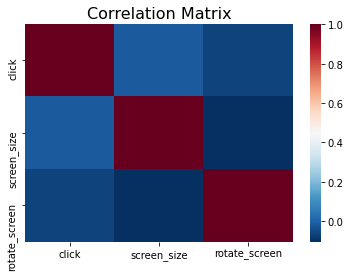

In [9]:
numeric_bank_df = db.select_dtypes(exclude="object")
corr_numeric = numeric_bank_df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16,) # we see a little bit correlation between screen size and click

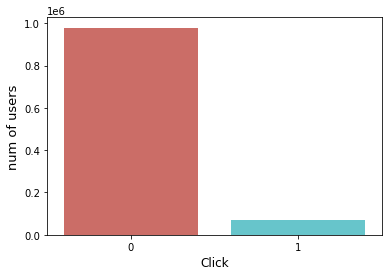

total number of no :  978599
total number of yes :  71011


In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.countplot(x = 'click', data=db, palette='hls')
plt.xlabel('Click', fontsize=12)
plt.ylabel('num of users', fontsize=13)
plt.show()
print("total number of no : ", len(db[db['click']==0]))
print("total number of yes : ", len(db[db['click']==1]))
# total amounts od clicks 

In [11]:

for col in db.columns:
    print(col, ':', len(db[col].unique()), 'labels')
    
'''app_id : 12088 labels
user_state : 51 labels
user_isp : 2735 labels
device_maker : 207 labels
device_model : 1866 labels
device_osv : 18 labels
click : 2 labels
week_day : 7 labels
part_of_day : 4 labels
screen_size : 314 labels
rotate_screen : 2 labels'''

app_id : 12088 labels
user_state : 51 labels
user_isp : 2735 labels
device_maker : 207 labels
device_model : 1866 labels
device_osv : 18 labels
click : 2 labels
week_day : 7 labels
part_of_day : 4 labels
screen_size : 314 labels
rotate_screen : 2 labels


'app_id : 12088 labels\nuser_state : 51 labels\nuser_isp : 2735 labels\ndevice_maker : 207 labels\ndevice_model : 1866 labels\ndevice_osv : 18 labels\nclick : 2 labels\nweek_day : 7 labels\npart_of_day : 4 labels\nscreen_size : 314 labels\nrotate_screen : 2 labels'

In [12]:
top10_app_id =['com.banananadco.blackjack', 'com.kiloo.subwaysurf','toy.blast.pop.cubes.puzzle', 'com.blackcircleapps.halloweenbingo',
       'com.mobilityware.CrownSolitaire', 'com.mobilityware.spider','com.mobilityware.freecell', 'com.RocketGames.ClassicSlots',
       'com.thumbspire.weedfirm2', 'com.spacegame.basic3']
for label in top10_app_id:
    db['app_id '+label] = np.where(db['app_id']==label, 1, 0)
    
top10_states = ['TX', 'CA', 'FL', 'IL', 'NY', 'GA', 'MI', 'NC', 'OH', 'PA']
for label in top10_states:
    db['state '+label] = np.where(db['user_state']==label, 1, 0)
    
top7_isp = ['T-Mobile USA', 'Spectrum', 'Comcast Cable', 'AT&T Wireless',
       'Sprint PCS', 'Verizon Wireless', 'AT&T U-verse']
for label in top7_isp:
    db['isp '+label] = np.where(db['user_isp']==label, 1, 0)

top7_Dmaker = ['Samsung', 'LG', 'Motorola', 'ZTE', 'ALCATEL', 'HTC', 'Google']
for label in top7_Dmaker:
    db['marker '+label] = np.where(db['device_maker']==label, 1, 0)
    
top7_Dmodel = ['LM-X210(G)', 'SM-J327T1', 'Moto E4', 'MP260', 'MS210', 'SM-G955U','SM-G950U']
for label in top7_Dmodel:
    db['model '+label] = np.where(db['device_model']==label, 1, 0)
    
top5_osv = ['7.0', '8.0.0', '7.1.1', '6.0.1', '7.1.2']
for label in top5_osv:
    db['osv '+label] = np.where(db['device_osv']==label, 1, 0)

parts_of_day = ['afternoon', 'evening', 'morning', 'night']
for label in parts_of_day:
    db[label] = np.where(db['part_of_day']==label, 1, 0)
    
days_of_week = ['Saturday', 'Thursday', 'Sunday', 'Tuesday', 'Monday', 'Wednesday','Friday']
for label in days_of_week:
    db[label] = np.where(db['week_day']==label, 1, 0)    

    
del db['app_id']
del db['user_state']
del db['user_isp']
del db['device_maker']
del db['device_model']
del db['device_osv']
del db['part_of_day']
del db['week_day']

In [13]:
clicks =  db['click'] #move decision col to the edge
del db['click']

In [14]:
db.head(3)

,screen_size,rotate_screen,app_id com.banananadco.blackjack,app_id com.kiloo.subwaysurf,app_id toy.blast.pop.cubes.puzzle,app_id com.blackcircleapps.halloweenbingo,app_id com.mobilityware.CrownSolitaire,app_id com.mobilityware.spider,app_id com.mobilityware.freecell,app_id com.RocketGames.ClassicSlots,...,evening,morning,night,Saturday,Thursday,Sunday,Tuesday,Monday,Wednesday,Friday
0,921600,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,921600,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,921600,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [15]:
print ("click and features data type: ", db.dtypes)

click and features data type:  screen_size                                  int64
rotate_screen                                int64
app_id com.banananadco.blackjack             int32
app_id com.kiloo.subwaysurf                  int32
app_id toy.blast.pop.cubes.puzzle            int32
app_id com.blackcircleapps.halloweenbingo    int32
app_id com.mobilityware.CrownSolitaire       int32
app_id com.mobilityware.spider               int32
app_id com.mobilityware.freecell             int32
app_id com.RocketGames.ClassicSlots          int32
app_id com.thumbspire.weedfirm2              int32
app_id com.spacegame.basic3                  int32
state TX                                     int32
state CA                                     int32
state FL                                     int32
state IL                                     int32
state NY                                     int32
state GA                                     int32
state MI                                     int32


In [17]:

clicks1= clicks[0:50000] #i'll try to seprate to chunks later if i've got time
db1=db[0:50000]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(db1, clicks1, test_size=0.20, stratify=clicks1)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  40000
number of test samples:  10000


In [19]:
from tqdm import tqdm_notebook as tqdm
import sklearn.externals
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [20]:
'''pipe_steps = [('scaler', StandardScaler()), ('decsT', DecisionTreeClassifier())]

check_params = {'decsT__criterion':['gini', 'entropy'], 
               'decsT__max_depth': np.arange(3, 15)}

pipeline = Pipeline(pipe_steps)
print(pipeline)'''

"pipe_steps = [('scaler', StandardScaler()), ('decsT', DecisionTreeClassifier())]\n\ncheck_params = {'decsT__criterion':['gini', 'entropy'], \n               'decsT__max_depth': np.arange(3, 15)}\n\npipeline = Pipeline(pipe_steps)\nprint(pipeline)"

In [21]:
'''print ("start fitting the data") # k fold cross-validation
import warnings
warnings.filterwarnings("ignore")


for cv in tqdm(range(3, 6)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, y_train)
    print("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, y_test)))
    print ("!!!! best fit parameters from GridSearchCV !!!!")
    print (create_grid.best_params_)

print ("out o' the loop")'''

'print ("start fitting the data") # k fold cross-validation\nimport warnings\nwarnings.filterwarnings("ignore")\n\n\nfor cv in tqdm(range(3, 6)):\n    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)\n    create_grid.fit(X_train, y_train)\n    print("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, y_test)))\n    print ("!!!! best fit parameters from GridSearchCV !!!!")\n    print (create_grid.best_params_)\n\nprint ("out o\' the loop")'

In [22]:
# preformance evaluation
DecsTreeModel = DecisionTreeClassifier(criterion='gini', max_depth=10)
DecsTreeModel.fit(X_train, y_train)


train_score = DecsTreeModel.score(X_train, y_train)
print ("score on the training data: ", train_score)
print ("\n")

test_score = DecsTreeModel.score(X_test, y_test)
print ("score on the test data: ", test_score)

score on the training data:  0.93405


score on the test data:  0.9289


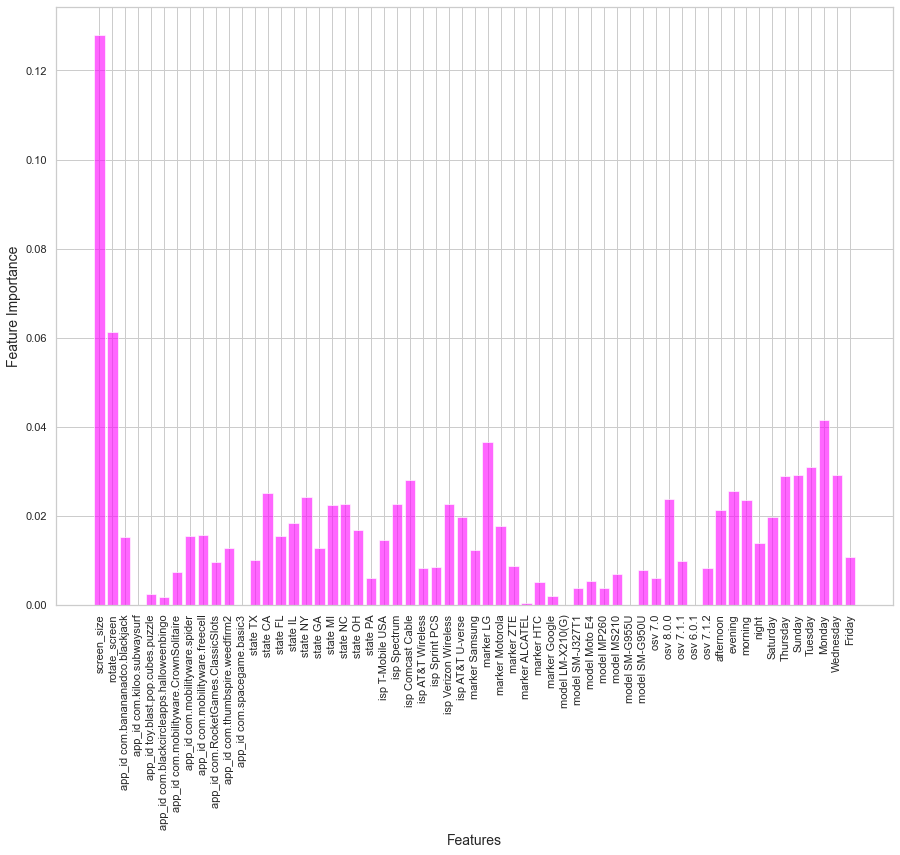

In [23]:
n_features = len(X_train.columns.values)

sns.set(style="whitegrid")

fig = plt.figure(figsize=(15, 11))
fig.tight_layout()
plt.bar(range(n_features), DecsTreeModel.feature_importances_, color="magenta", align="center", alpha=0.6)
plt.xticks(np.arange(n_features), X_train.columns.values, rotation=90, fontsize=11)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Feature Importance", fontsize=14)
plt.savefig("Feature_Importance.png", dpi=300, bbox_inches='tight')